In [6]:
import matplotlib.pyplot as plt
import pandas as pd
from time import time
import numpy as np
import os

In [7]:
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size' : 14.4,
#     'font.size' : 17.28,
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [8]:
def block_average(data,n,coarse_sampling=1,save_stds=False):
    coarse_data = 0
    if coarse_sampling == 1:
        coarse_data = data
    else:
        coarse_data = pd.DataFrame(data=[],columns=data.keys())
        for i in np.arange(0,len(data))[::coarse_sampling]:
            coarse_data.loc[len(coarse_data)] = data.values[i]
    if n == 1:
        return coarse_data
    
    new_keys = []
    if save_stds:
        for k in coarse_data.keys():
            new_keys.append(k)
            new_keys.append(k+'_std')
    else:
        new_keys = coarse_data.keys()
    new_data = pd.DataFrame(data=[],columns=new_keys)
    
    for i in range(int(len(coarse_data)/n)):
        v = []
        for k in coarse_data.keys():
            v.append(np.mean(coarse_data[k][n*i:n*(i + 1)]))
            if save_stds:
                v.append(np.std(coarse_data[k][n*i:n*(i + 1)],ddof=1))
        new_data.loc[len(new_data)] = v
    
    return new_data

In [16]:
def index_keys(keys,iks=['k','time']):
    for k in keys:
        iks.append(k)
        iks.append(k+'_std')
    return np.array(iks)

D = 2
N = 64
suffix = '_free'

ofile = 'results_a.csv'
average_keys = ['m', 'abs_m', 'a', 'wall_density']

big_folder = 'sim'
sub_folder = big_folder + ('/D%d_N%d' %(D,N)) + suffix
if not os.path.exists(sub_folder):
    raise FileNotFoundError('Folder does not exist')
    
if not os.path.exists(sub_folder+'/'+ofile):
    df = pd.DataFrame(data=[],columns=index_keys(average_keys))
else:
    raise FileExistsError(ofile + ' exists')
    
df_in = pd.read_csv(sub_folder+'/results.csv')
ks = df_in['k']
Ns = [N]*D

M = 20 #block averaging parameter
min_index = 2
    
for i,k in enumerate(ks):
    start_time = time()
    raw_data=pd.read_csv(sub_folder+'/evolution_k%.4f.csv' %k)
    
    b_data = block_average(raw_data,M)
    avgs = []
    for key in average_keys:
        if key == 'abs_m':
            avgs.append(np.mean(np.abs(np.array(b_data['m'][min_index:]))))
            avgs.append(np.std(np.abs(np.array(b_data['m'][min_index:])),ddof=1)/np.sqrt(len(b_data['step'][min_index:])))
        else:
            avgs.append(np.mean(b_data[key][min_index:]))
            avgs.append(np.std(b_data[key][min_index:],ddof=1)/np.sqrt(len(b_data['step'][min_index:])))
        
    t = time() - start_time
    df.loc[len(df)] = [k,t] + avgs
    print(i,k,t)
    
df.to_csv(sub_folder+'/'+ofile, index=False)

FileNotFoundError: Folder does not exist

<IPython.core.display.Javascript object>


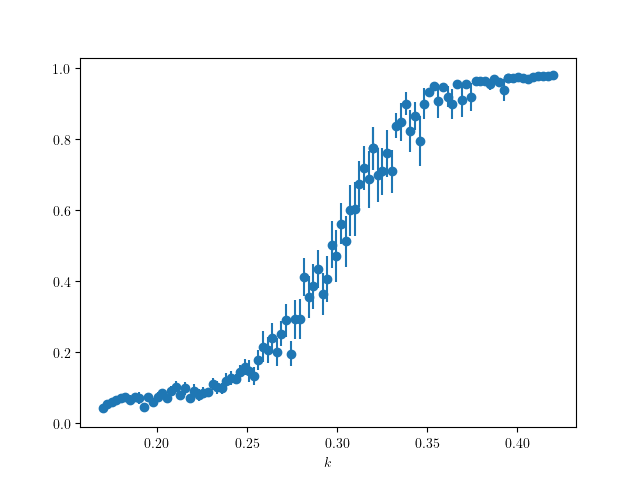

Text(0.5, 0, '$k$')

In [12]:
%matplotlib notebook
keys = ['abs_m','a','wall_density'][:1]

plt.figure()
for key in keys:
    plt.errorbar(df['k'],df[key],yerr=df[key+'_std'],label=key,fmt='o')
plt.legend()
plt.xlabel('$k$')